In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.2
Pytorch version: 2.1.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /<username>/miniconda3/envs/cv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSIO

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image",allow_smaller=True),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image",allow_smaller=True),
    ]
)

In [4]:
# from monai.data import load_decathlon_datalist

data_dir = "data/Task09_Spleen/"
split_json = "dataset.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
# val_files = load_decathlon_datalist(datasets, True, "test")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=41,
    cache_rate=1.0,
    num_workers=1,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
# val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
# val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
val_loader = train_loader

Loading dataset: 100%|██████████| 41/41 [01:34<00:00,  2.31s/it]


In [ ]:
datalist
# val_files

[{'image': 'data/Task09_Spleen/imagesTr/spleen_19.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_19.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_31.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_31.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_52.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_52.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_40.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_40.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_3.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_3.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_17.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_17.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_21.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_21.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_33.nii.gz',
  'label': 'data/Task09_Spleen/labelsTr/spleen_33.nii.gz'},
 {'image': 'data/Task09_Spleen/imagesTr/spleen_9.n

In [5]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
    "spleen_19.nii.gz": 94,
}
case_num = 0
# print(train_ds[case_num].keys())
# exit()
img_name = os.path.split(train_ds[case_num][0]["image"].meta["filename_or_obj"])[1]
print(img_name)
img = train_ds[case_num][0]["image"]
label = train_ds[case_num][0]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")

spleen_19.nii.gz
image shape: torch.Size([1, 96, 96, 96]), label shape: torch.Size([1, 96, 96, 96])


In [31]:
print(len(train_ds[0]))
# img_name = os.path.split(train_ds[3][1]["image"].meta["filename_or_obj"])
# print(img_name)

4


In [18]:
img_name

'spleen_19.nii.gz'

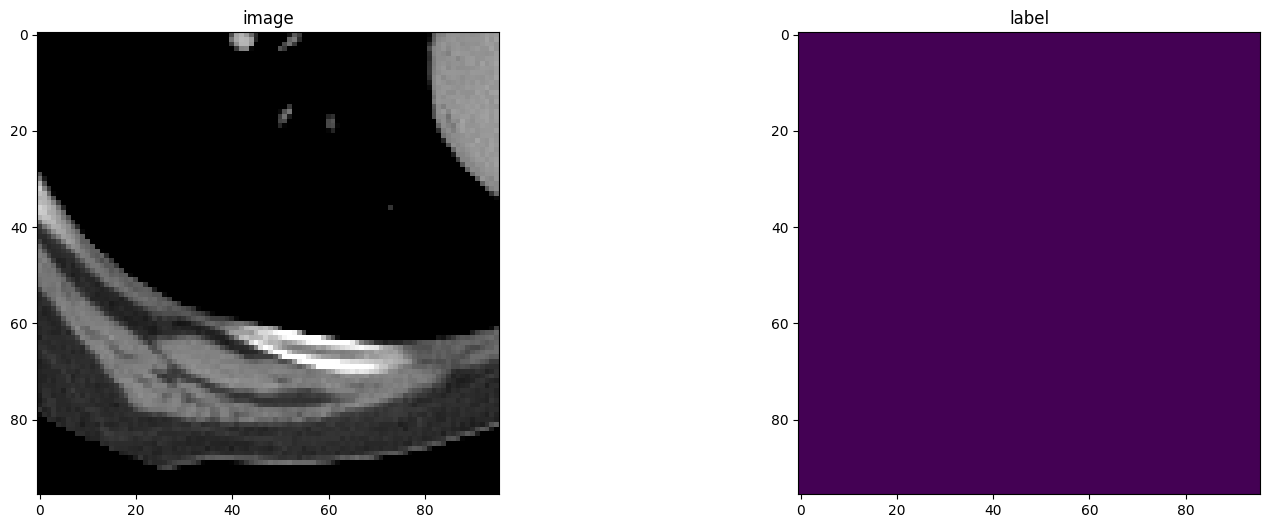

In [45]:
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
# plt.imshow(img[0, :, :, :].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
# plt.imshow(label[0, :, :, :].detach().cpu())

plt.show()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [12]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("model", "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [13]:
max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 25000 Steps) (loss=0.51895):  22%|██▏       | 9/41 [00:15<01:46,  3.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8736081123352051 Current Avg. Dice: 0.8736081123352051


Training (1000 / 25000 Steps) (loss=0.39876):  41%|████▏     | 17/41 [00:21<01:27,  3.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9164705276489258 Current Avg. Dice: 0.9164705276489258


Training (1500 / 25000 Steps) (loss=0.39840):  61%|██████    | 25/41 [00:24<00:55,  3.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9185792803764343 Current Avg. Dice: 0.9185792803764343


Training (2000 / 25000 Steps) (loss=0.47266):  80%|████████  | 33/41 [00:28<00:26,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9185792803764343 Current Avg. Dice: 0.9181393980979919


Training (2500 / 25000 Steps) (loss=0.23005): 100%|██████████| 41/41 [00:32<00:00,  3.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.925720751285553 Current Avg. Dice: 0.925720751285553


Training (3000 / 25000 Steps) (loss=0.31183):  20%|█▉        | 8/41 [00:18<02:20,  4.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.940642774105072 Current Avg. Dice: 0.940642774105072


Training (3500 / 25000 Steps) (loss=0.12724):  39%|███▉      | 16/41 [00:20<01:21,  3.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.940642774105072 Current Avg. Dice: 0.9222354292869568


Training (4000 / 25000 Steps) (loss=0.18761):  59%|█████▊    | 24/41 [00:23<00:54,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.940642774105072 Current Avg. Dice: 0.9188641905784607


Training (4500 / 25000 Steps) (loss=0.30781):  78%|███████▊  | 32/41 [00:28<00:31,  3.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9407059550285339 Current Avg. Dice: 0.9407059550285339


Training (5000 / 25000 Steps) (loss=0.11662):  98%|█████████▊| 40/41 [00:32<00:03,  3.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.956190824508667


Training (5500 / 25000 Steps) (loss=0.28194):  17%|█▋        | 7/41 [00:14<01:58,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9539971947669983


Training (6000 / 25000 Steps) (loss=0.12080):  37%|███▋      | 15/41 [00:19<01:24,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9497277140617371


Training (6500 / 25000 Steps) (loss=0.17948):  56%|█████▌    | 23/41 [00:23<00:57,  3.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9531497359275818


Training (7000 / 25000 Steps) (loss=0.29414):  76%|███████▌  | 31/41 [00:27<00:31,  3.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9410068392753601


Training (7500 / 25000 Steps) (loss=0.27140):  95%|█████████▌| 39/41 [00:30<00:06,  3.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9518494009971619


Training (8000 / 25000 Steps) (loss=0.30581):  15%|█▍        | 6/41 [00:14<02:10,  3.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9432704448699951


Training (8500 / 25000 Steps) (loss=0.08751):  34%|███▍      | 14/41 [00:18<01:27,  3.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9551199674606323


Training (9000 / 25000 Steps) (loss=0.51007):  54%|█████▎    | 22/41 [00:22<01:01,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.956190824508667 Current Avg. Dice: 0.9558896422386169


Training (9500 / 25000 Steps) (loss=0.17044):  73%|███████▎  | 30/41 [00:27<00:38,  3.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9588298201560974 Current Avg. Dice: 0.9588298201560974


Training (10000 / 25000 Steps) (loss=0.27843):  93%|█████████▎| 38/41 [00:30<00:09,  3.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9588298201560974 Current Avg. Dice: 0.9569572806358337


Training (10500 / 25000 Steps) (loss=0.08891):  12%|█▏        | 5/41 [00:15<02:35,  4.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9624605774879456 Current Avg. Dice: 0.9624605774879456


Training (11000 / 25000 Steps) (loss=0.15875):  32%|███▏      | 13/41 [00:18<01:30,  3.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9624605774879456 Current Avg. Dice: 0.9514578580856323


Training (11500 / 25000 Steps) (loss=0.27158):  51%|█████     | 21/41 [00:23<01:08,  3.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9643076658248901 Current Avg. Dice: 0.9643076658248901


Training (12000 / 25000 Steps) (loss=0.15658):  71%|███████   | 29/41 [00:26<00:38,  3.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9643076658248901 Current Avg. Dice: 0.9609026908874512


Training (12500 / 25000 Steps) (loss=0.26477):  90%|█████████ | 37/41 [00:30<00:12,  3.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9643076658248901 Current Avg. Dice: 0.9539240598678589


Training (13000 / 25000 Steps) (loss=0.27998):  10%|▉         | 4/41 [00:14<02:58,  4.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9670592546463013 Current Avg. Dice: 0.9670592546463013


Training (X / X Steps) (loss=X.X):   0%|          | 0/41 [00:00<?, ?it/s]